In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import json
import matplotlib.animation as anim
from IPython import display
from matplotlib import animation
from math import *
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = np.load('drive/MyDrive/DROMB8131 Sports Analytics Project/bball_data_cleaned/data/train.npz')
test_data = np.load('drive/MyDrive/DROMB8131 Sports Analytics Project/bball_data_cleaned/data/test.npz')

In [ ]:
lst = train_data.files

numpy_data = train_data['data']

In [ ]:
tot_nb_of_seq = numpy_data.shape[0]
len_of_seq = numpy_data.shape[1]
len_of_observation = numpy_data.shape[2]
print('shape of data: ' + str(numpy_data.shape) + 'is (number of sequence, number of data points per sequence, size of data')
print('where the 22 data are the (x, y) positions of [ball, 5 offense players, 5 defense players]')

In [ ]:
print(ball_x[0], ball_x[1])
print(numpy_data[0][0][0], numpy_data[0][1][0])

36.507 34.941
36.507 34.941


In [ ]:
numpy_data.shape[1]*numpy_data.shape[0]

5200150

In [ ]:
d = {'ball_x':[numpy_data[i][j][0] for i in range(numpy_data.shape[0]) for j in range(numpy_data.shape[1])], 
     'ball_y':[numpy_data[i][j][1] for i in range(numpy_data.shape[0]) for j in range(numpy_data.shape[1])]}
for k in range(5):
  d[f'player_h{k+1}x'] = [numpy_data[i][j][2 + 2*k] for i in range(numpy_data.shape[0]) for j in range(numpy_data.shape[1])]
  d[f'player_h{k+1}y'] = [numpy_data[i][j][3 + 2*k] for i in range(numpy_data.shape[0]) for j in range(numpy_data.shape[1])]
  d[f'player_a{k+1}x'] = [numpy_data[i][j][12 + 2*k] for i in range(numpy_data.shape[0]) for j in range(numpy_data.shape[1])]
  d[f'player_a{k+1}y'] = [numpy_data[i][j][13 + 2*k] for i in range(numpy_data.shape[0]) for j in range(numpy_data.shape[1])]

data = pd.DataFrame(d, index = np.arange(0, numpy_data.shape[0]*numpy_data.shape[1], 1))
data['index'] = data.index

data['action'] = data['index'].apply(lambda x: x//50)
data['frame'] = data['index'].apply(lambda x: x%50)

In [ ]:
util_data = data[:10000].drop(columns = ['index'])
util_data

,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y,action,frame
0,36.507,39.350,18.6900,47.883,20.585,42.337,65.627,37.171,28.732,35.769,44.717,19.284,46.886,39.394,43.345,10.0840,25.343,16.602,36.6770,40.4970,21.3370,23.843,0,0
1,34.941,38.831,16.7450,47.850,18.758,42.402,63.680,36.548,27.837,35.821,42.882,19.133,44.534,38.184,41.579,9.7938,24.777,16.601,34.3950,39.8780,20.0700,24.229,0,1
2,33.812,38.373,15.0330,47.683,17.122,42.501,61.744,35.971,26.989,35.694,41.221,18.919,42.202,36.927,39.934,9.5226,24.224,16.470,32.3290,38.9650,19.0970,24.510,0,2
3,31.883,36.740,13.5320,47.422,15.612,42.571,59.841,35.361,26.141,35.427,39.646,18.616,39.918,35.669,38.374,9.3071,23.678,16.247,30.1210,37.9920,18.3750,24.726,0,3
4,27.635,35.908,12.2350,47.096,14.187,42.597,57.936,34.731,25.159,35.181,38.121,18.304,37.699,34.510,36.969,9.1729,23.097,16.026,27.8780,37.2810,17.7550,24.814,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24.898,43.811,10.3290,47.740,11.560,39.080,18.217,32.518,14.841,33.678,26.447,42.977,25.011,39.308,26.674,12.1280,17.052,32.223,7.2961,10.4680,6.2273,17.405,199,45
9996,25.610,44.174,9.5075,47.731,11.283,39.214,17.259,31.884,14.784,33.723,26.968,43.138,25.554,39.795,26.306,12.0670,17.867,30.589,7.2867,10.1920,6.1847,17.218,199,46
9997,26.133,45.399,8.6860,47.774,10.974,39.446,16.222,31.331,14.552,33.545,27.202,43.315,26.035,40.130,25.996,12.0540,18.696,28.691,7.1920,9.9881,6.1676,17.193,199,47
9998,26.504,45.829,7.9325,47.944,10.686,39.684,15.313,30.536,14.138,33.264,27.272,43.366,26.364,40.366,25.788,12.1000,18.960,27.229,7.0201,9.8184,6.1705,17.345,199,48


In [ ]:
util_data = data[:10000].drop(columns = ['index'])

frame_col = util_data.frame
action_col = util_data.action

util_data.drop(columns = ['frame', 'action'], inplace = True)

util_data.insert(0, 'frame', frame_col)
util_data.insert(0, 'action', action_col)

In [ ]:
util_data.to_csv('raw_train.csv')

In [ ]:
util_data

,action,frame,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y
0,0,0,36.507,39.350,18.6900,47.883,20.585,42.337,65.627,37.171,28.732,35.769,44.717,19.284,46.886,39.394,43.345,10.0840,25.343,16.602,36.6770,40.4970,21.3370,23.843
1,0,1,34.941,38.831,16.7450,47.850,18.758,42.402,63.680,36.548,27.837,35.821,42.882,19.133,44.534,38.184,41.579,9.7938,24.777,16.601,34.3950,39.8780,20.0700,24.229
2,0,2,33.812,38.373,15.0330,47.683,17.122,42.501,61.744,35.971,26.989,35.694,41.221,18.919,42.202,36.927,39.934,9.5226,24.224,16.470,32.3290,38.9650,19.0970,24.510
3,0,3,31.883,36.740,13.5320,47.422,15.612,42.571,59.841,35.361,26.141,35.427,39.646,18.616,39.918,35.669,38.374,9.3071,23.678,16.247,30.1210,37.9920,18.3750,24.726
4,0,4,27.635,35.908,12.2350,47.096,14.187,42.597,57.936,34.731,25.159,35.181,38.121,18.304,37.699,34.510,36.969,9.1729,23.097,16.026,27.8780,37.2810,17.7550,24.814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,199,45,24.898,43.811,10.3290,47.740,11.560,39.080,18.217,32.518,14.841,33.678,26.447,42.977,25.011,39.308,26.674,12.1280,17.052,32.223,7.2961,10.4680,6.2273,17.405
9996,199,46,25.610,44.174,9.5075,47.731,11.283,39.214,17.259,31.884,14.784,33.723,26.968,43.138,25.554,39.795,26.306,12.0670,17.867,30.589,7.2867,10.1920,6.1847,17.218
9997,199,47,26.133,45.399,8.6860,47.774,10.974,39.446,16.222,31.331,14.552,33.545,27.202,43.315,26.035,40.130,25.996,12.0540,18.696,28.691,7.1920,9.9881,6.1676,17.193
9998,199,48,26.504,45.829,7.9325,47.944,10.686,39.684,15.313,30.536,14.138,33.264,27.272,43.366,26.364,40.366,25.788,12.1000,18.960,27.229,7.0201,9.8184,6.1705,17.345


# Function

In [ ]:
full_data = pd.read_csv('drive/MyDrive/DROMB8131 Sports Analytics Project/cleaned_processed_data/raw_train.csv')

In [ ]:
def distance_from_basket(dataframe_row):
    basket_left = [12.0,25.0]
    ball_carrier = dataframe_row['ball_carrier']
    baller = [dataframe_row['player_h'+str(int(ball_carrier))+'x'],dataframe_row['player_h'+str(int(ball_carrier))+'y']]
    distance_left = [baller[0]-basket_left[0],baller[1]-basket_left[1]]
    distance_left[0], distance_left[1] = distance_left[0]*distance_left[0], distance_left[1]*distance_left[1]
    return sqrt(sum(distance_left))

def distance_to_closest_def(dataframe_row,defend_team="a"):
    ball = [dataframe_row['ball_x'],dataframe_row['ball_y']]
    index = dataframe_row.index[0]
    ball[0], ball[1] = ball[0][index], ball[1][index]
    defenders = [[dataframe_row['player_' + defend_team + str(i+1) +'x'][index],dataframe_row['player_' + defend_team + str(i+1) +'y'][index]]for i in range(5)]
    distance_to_def = [(defenders[i][0]-ball[0])*(defenders[i][0]-ball[0])+(defenders[i][1]-ball[1])*(defenders[i][1]-ball[1]) for i in range(5)]
    return sqrt(min(distance_to_def))
    
def ball_carrier(dataframe_row):
    ball = [dataframe_row['ball_x'],dataframe_row['ball_y']]
    index = dataframe_row.index[0]
    try:
        ball[0], ball[1] = ball[0][index], ball[1][index]
        home_team = [[dataframe_row['player_h' + str(i+1) +'x'][index],dataframe_row['player_h' + str(i+1) +'y'][index]]for i in range(5)]
    except:
        home_team = [[dataframe_row['player_h' + str(i+1) +'x'],dataframe_row['player_h' + str(i+1) +'y']] for i in range(5)]
    distance_to_ball = [(home_team[i][0]-ball[0])*(home_team[i][0]-ball[0])+(home_team[i][1]-ball[1])*(home_team[i][1]-ball[1]) for i in range(5)]
    return distance_to_ball.index(min(distance_to_ball))+1
    
def closest_def(dataframe_row):
    ball_carrier = dataframe_row['ball_carrier']
    baller = [dataframe_row['player_h'+str(int(ball_carrier))+'x'],dataframe_row['player_h'+str(int(ball_carrier))+'y']]
    defenders = [[dataframe_row['player_a' + str(i+1) +'x'],dataframe_row['player_a' + str(i+1) +'y']] for i in range(5)]
    distance_to_def = [(defenders[i][0]-baller[0])*(defenders[i][0]-baller[0])+(defenders[i][1]-baller[1])*(defenders[i][1]-baller[1]) for i in range(5)]
    return sqrt(min(distance_to_def)), distance_to_def.index(min(distance_to_def))+1

def calcul_probability(dataframe_row):
    coef = [0.258704121,-0.011590332,0.001705179,0.019098643,-0.00499288] #Calculated on excel
    dist_basket = dataframe_row['dist_from_basket']
    dist_def = dataframe_row['dist_to_closest_def']
    return 1/(1+exp(-(coef[0] + 10*coef[1]*dist_basket + coef[2]*dist_basket*dist_basket + 10*coef[3]*dist_def + coef[4]*dist_def*dist_def)))

def correct_change_carrier(dataframe):
    dataframe['diff_carry'] = dataframe['ball_carrier'].diff()
    diff_list = dataframe[dataframe['diff_carry']!=0].index.values.tolist()
    for i in range(len(diff_list)-1):
        if diff_list[i+1] <= diff_list[i] + 5:
            dataframe['ball_carrier'][diff_list[i]:diff_list[i+1]+1] = dataframe['ball_carrier'][diff_list[i]-1]
    return None
   
full_data["ball_carrier"] = full_data.apply(lambda x: ball_carrier(x), axis=1)
correct_change_carrier(full_data)
full_data["dist_from_basket"] = full_data.apply(lambda x: distance_from_basket(x), axis=1)
full_data["closest_def"] = full_data.apply(lambda x: closest_def(x)[1], axis=1)
full_data["dist_to_closest_def"] = full_data.apply(lambda x: closest_def(x)[0], axis=1)
full_data["shoot_prob"] = full_data.apply(lambda x: calcul_probability(x), axis=1)
full_data['diff_carry'] = full_data['ball_carrier'].diff()
full_data['diff_action'] = full_data['action'].diff()
full_data['pass'] = full_data.apply(lambda x: x['diff_carry']!=0 and x['diff_action']==0, axis=1)
full_data = full_data.drop(['diff_carry', 'diff_action'],axis=1)
full_data['pass'] = full_data['pass'].astype(int)


full_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,action,frame,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y,ball_carrier,dist_from_basket,closest_def,dist_to_closest_def,shoot_prob,pass
0,0,0,0,36.507,39.350,18.6900,47.883,20.585,42.337,65.627,37.171,28.732,35.769,44.717,19.284,46.886,39.394,43.345,10.0840,25.343,16.602,36.6770,40.4970,21.3370,23.843,5,29.139515,2,9.245378,0.417800,0
1,1,0,1,34.941,38.831,16.7450,47.850,18.758,42.402,63.680,36.548,27.837,35.821,42.882,19.133,44.534,38.184,41.579,9.7938,24.777,16.601,34.3950,39.8780,20.0700,24.229,5,26.886631,2,7.711460,0.389596,0
2,2,0,2,33.812,38.373,15.0330,47.683,17.122,42.501,61.744,35.971,26.989,35.694,41.221,18.919,42.202,36.927,39.934,9.5226,24.224,16.470,32.3290,38.9650,19.0970,24.510,5,24.663525,2,6.262191,0.362983,0
3,3,0,3,31.883,36.740,13.5320,47.422,15.612,42.571,59.841,35.361,26.141,35.427,39.646,18.616,39.918,35.669,38.374,9.3071,23.678,16.247,30.1210,37.9920,18.3750,24.726,5,22.297146,2,4.734937,0.335038,0
4,4,0,4,27.635,35.908,12.2350,47.096,14.187,42.597,57.936,34.731,25.159,35.181,38.121,18.304,37.699,34.510,36.969,9.1729,23.097,16.026,27.8780,37.2810,17.7550,24.814,5,20.073212,2,3.435544,0.313553,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,199,45,24.898,43.811,10.3290,47.740,11.560,39.080,18.217,32.518,14.841,33.678,26.447,42.977,25.011,39.308,26.674,12.1280,17.052,32.223,7.2961,10.4680,6.2273,17.405,3,23.062704,3,3.940007,0.303139,0
9996,9996,199,46,25.610,44.174,9.5075,47.731,11.283,39.214,17.259,31.884,14.784,33.723,26.968,43.138,25.554,39.795,26.306,12.0670,17.867,30.589,7.2867,10.1920,6.1847,17.218,3,23.516549,3,3.629744,0.289774,0
9997,9997,199,47,26.133,45.399,8.6860,47.774,10.974,39.446,16.222,31.331,14.552,33.545,27.202,43.315,26.035,40.130,25.996,12.0540,18.696,28.691,7.1920,9.9881,6.1676,17.193,3,23.802101,3,3.392066,0.280174,0
9998,9998,199,48,26.504,45.829,7.9325,47.944,10.686,39.684,15.313,30.536,14.138,33.264,27.272,43.366,26.364,40.366,25.788,12.1000,18.960,27.229,7.0201,9.8184,6.1705,17.345,3,23.886062,3,3.134400,0.271443,0


In [ ]:
try:
  full_data.drop(columns = ['Unnamed: 0'], inplace=True)
except:
  pass
full_data.describe()

,action,frame,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y,ball_carrier,dist_from_basket,closest_def,dist_to_closest_def,shoot_prob,pass
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,99.500000,24.500000,26.468514,26.344178,15.347678,37.398513,13.81669,32.342889,25.880983,31.040321,21.285220,28.680672,23.274475,20.095102,18.754118,22.018876,15.287836,13.306005,13.511162,18.045286,16.538889,24.722944,13.672266,25.441302,2.92740,20.337228,2.87570,5.344145,0.391080,0.032900
std,57.737192,14.431591,10.758096,12.518658,9.788944,11.406657,6.59795,7.953936,10.623670,10.537738,8.483473,7.598224,11.031577,10.648229,8.233817,7.983719,8.664540,10.787525,6.433774,7.754204,8.205805,10.572314,5.459894,6.957431,1.28269,7.474876,1.25754,2.688013,0.084575,0.178384
min,0.000000,0.000000,-2.761000,0.213700,0.120870,0.131760,-1.69720,5.202400,1.850200,1.141500,3.619400,4.717200,-2.780700,0.454090,2.095100,5.981200,-2.203400,-0.014500,1.020900,1.063600,-0.818100,-2.149500,1.749600,6.824700,1.00000,0.346562,1.00000,0.133126,0.159881,0.000000
25%,49.750000,12.000000,18.425750,15.947750,7.198250,32.557500,8.60490,28.552000,18.349000,25.268500,15.482000,24.142000,14.381000,12.532500,12.000750,16.198750,7.933550,4.251375,8.628100,12.449000,10.144500,15.848000,9.274150,19.250500,2.00000,14.526422,2.00000,3.344265,0.332681,0.000000
50%,99.500000,24.500000,26.832000,27.062000,12.819000,40.460500,12.75950,33.940500,26.908500,32.418000,20.505000,29.414500,23.846500,17.814500,18.396000,20.858000,13.572500,12.015000,12.108000,16.517500,16.182500,23.819000,13.111500,25.020500,3.00000,20.756556,3.00000,5.197050,0.382128,0.000000
75%,149.250000,37.000000,34.439000,36.590750,22.912500,46.967000,18.15350,38.209000,32.674000,38.613250,26.979750,34.148500,30.732000,26.681000,24.121250,27.218250,21.985500,17.153000,17.876000,21.348750,22.804500,33.506000,17.639000,31.008000,4.00000,25.810577,4.00000,6.848695,0.443703,0.000000
max,199.000000,49.000000,93.996000,50.000000,63.235000,50.940000,43.57900,48.240000,77.816000,49.715000,76.199000,44.803000,72.625000,48.287000,68.730000,44.058000,51.989000,48.812000,42.055000,47.325000,48.191000,48.725000,39.597000,47.296000,5.00000,65.937378,5.00000,42.380483,0.713774,1.000000


In [ ]:
full_data

,action,frame,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y,ball_carrier,dist_from_basket,closest_def,dist_to_closest_def,shoot_prob,pass
0,0,0,36.507,39.350,18.6900,47.883,20.585,42.337,65.627,37.171,28.732,35.769,44.717,19.284,46.886,39.394,43.345,10.0840,25.343,16.602,36.6770,40.4970,21.3370,23.843,5,29.139515,2,9.245378,0.417800,0
1,0,1,34.941,38.831,16.7450,47.850,18.758,42.402,63.680,36.548,27.837,35.821,42.882,19.133,44.534,38.184,41.579,9.7938,24.777,16.601,34.3950,39.8780,20.0700,24.229,5,26.886631,2,7.711460,0.389596,0
2,0,2,33.812,38.373,15.0330,47.683,17.122,42.501,61.744,35.971,26.989,35.694,41.221,18.919,42.202,36.927,39.934,9.5226,24.224,16.470,32.3290,38.9650,19.0970,24.510,5,24.663525,2,6.262191,0.362983,0
3,0,3,31.883,36.740,13.5320,47.422,15.612,42.571,59.841,35.361,26.141,35.427,39.646,18.616,39.918,35.669,38.374,9.3071,23.678,16.247,30.1210,37.9920,18.3750,24.726,5,22.297146,2,4.734937,0.335038,0
4,0,4,27.635,35.908,12.2350,47.096,14.187,42.597,57.936,34.731,25.159,35.181,38.121,18.304,37.699,34.510,36.969,9.1729,23.097,16.026,27.8780,37.2810,17.7550,24.814,5,20.073212,2,3.435544,0.313553,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,199,45,24.898,43.811,10.3290,47.740,11.560,39.080,18.217,32.518,14.841,33.678,26.447,42.977,25.011,39.308,26.674,12.1280,17.052,32.223,7.2961,10.4680,6.2273,17.405,3,23.062704,3,3.940007,0.303139,0
9996,199,46,25.610,44.174,9.5075,47.731,11.283,39.214,17.259,31.884,14.784,33.723,26.968,43.138,25.554,39.795,26.306,12.0670,17.867,30.589,7.2867,10.1920,6.1847,17.218,3,23.516549,3,3.629744,0.289774,0
9997,199,47,26.133,45.399,8.6860,47.774,10.974,39.446,16.222,31.331,14.552,33.545,27.202,43.315,26.035,40.130,25.996,12.0540,18.696,28.691,7.1920,9.9881,6.1676,17.193,3,23.802101,3,3.392066,0.280174,0
9998,199,48,26.504,45.829,7.9325,47.944,10.686,39.684,15.313,30.536,14.138,33.264,27.272,43.366,26.364,40.366,25.788,12.1000,18.960,27.229,7.0201,9.8184,6.1705,17.345,3,23.886062,3,3.134400,0.271443,0


In [ ]:
image = mpimg.imread("drive/MyDrive/DROMB8131 Sports Analytics Project/bball_data_cleaned/data/court.png")

size = np.shape(image)
reshape_size = [size[0]/50, size[1]/100]

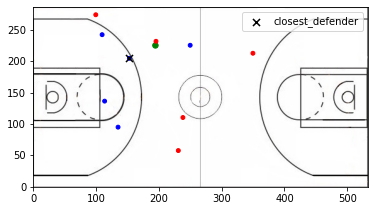

In [ ]:
fig, ax = plt.subplots()
ball = full_data[['ball_x', 'ball_y']].iloc[0]
home_players_columns = [f'player_h{i}x' for i in range(1, 6)] + [f'player_h{i}y' for i in range(1, 6)]
home_players = full_data[home_players_columns].iloc[0]
away_players_columns = [f'player_a{i}x' for i in range(1, 6)] + [f'player_a{i}y' for i in range(1, 6)]
away_players = full_data[away_players_columns].iloc[0]

ax.set_ylim(0, size[0])
ax.set_xlim(0, size[1])

ball_position = [ball[0]*reshape_size[1], ball[1]*reshape_size[0]]
home_team_positions = [home_players[:5]*reshape_size[1], home_players[5:]*reshape_size[0]]
away_team_positions = [away_players[:5]*reshape_size[1], away_players[5:]*reshape_size[0]]

x = list([ball_position[0]]) + list(home_team_positions[0]) + list(away_team_positions[0])
y = list([ball_position[1]]) + list(home_team_positions[1]) + list(away_team_positions[1])

s = [30] + [15]*10
c = ['g'] + ['r']*5 + ['blue']*5
scat = ax.scatter(x, y, s, c)
scat2 = ax.scatter([away_players[1]*reshape_size[1]], [away_players[6]*reshape_size[0]], s = 50, c = 'black', marker = 'x', label = 'closest_defender')
plt.legend()
ax.imshow(image)

In [ ]:
closest_def = full_data['closest_def'].iloc[0]
closest_def_position = full_data[[f'player_a{closest_def}x'] + [f'player_a{closest_def}y']]

closest_def_position

,player_a2x,player_a2y
0,28.732,35.769
1,27.837,35.821
2,26.989,35.694
3,26.141,35.427
4,25.159,35.181
...,...,...
9995,14.841,33.678
9996,14.784,33.723
9997,14.552,33.545
9998,14.138,33.264


In [ ]:
full_data

,action,frame,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y,ball_carrier,dist_from_basket,closest_def,dist_to_closest_def,shoot_prob,pass
0,0,0,36.507,39.350,18.6900,47.883,20.585,42.337,65.627,37.171,28.732,35.769,44.717,19.284,46.886,39.394,43.345,10.0840,25.343,16.602,36.6770,40.4970,21.3370,23.843,5,29.139515,2,9.245378,0.417800,0
1,0,1,34.941,38.831,16.7450,47.850,18.758,42.402,63.680,36.548,27.837,35.821,42.882,19.133,44.534,38.184,41.579,9.7938,24.777,16.601,34.3950,39.8780,20.0700,24.229,5,26.886631,2,7.711460,0.389596,0
2,0,2,33.812,38.373,15.0330,47.683,17.122,42.501,61.744,35.971,26.989,35.694,41.221,18.919,42.202,36.927,39.934,9.5226,24.224,16.470,32.3290,38.9650,19.0970,24.510,5,24.663525,2,6.262191,0.362983,0
3,0,3,31.883,36.740,13.5320,47.422,15.612,42.571,59.841,35.361,26.141,35.427,39.646,18.616,39.918,35.669,38.374,9.3071,23.678,16.247,30.1210,37.9920,18.3750,24.726,5,22.297146,2,4.734937,0.335038,0
4,0,4,27.635,35.908,12.2350,47.096,14.187,42.597,57.936,34.731,25.159,35.181,38.121,18.304,37.699,34.510,36.969,9.1729,23.097,16.026,27.8780,37.2810,17.7550,24.814,5,20.073212,2,3.435544,0.313553,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,199,45,24.898,43.811,10.3290,47.740,11.560,39.080,18.217,32.518,14.841,33.678,26.447,42.977,25.011,39.308,26.674,12.1280,17.052,32.223,7.2961,10.4680,6.2273,17.405,3,23.062704,3,3.940007,0.303139,0
9996,199,46,25.610,44.174,9.5075,47.731,11.283,39.214,17.259,31.884,14.784,33.723,26.968,43.138,25.554,39.795,26.306,12.0670,17.867,30.589,7.2867,10.1920,6.1847,17.218,3,23.516549,3,3.629744,0.289774,0
9997,199,47,26.133,45.399,8.6860,47.774,10.974,39.446,16.222,31.331,14.552,33.545,27.202,43.315,26.035,40.130,25.996,12.0540,18.696,28.691,7.1920,9.9881,6.1676,17.193,3,23.802101,3,3.392066,0.280174,0
9998,199,48,26.504,45.829,7.9325,47.944,10.686,39.684,15.313,30.536,14.138,33.264,27.272,43.366,26.364,40.366,25.788,12.1000,18.960,27.229,7.0201,9.8184,6.1705,17.345,3,23.886062,3,3.134400,0.271443,0


In [ ]:
full_data.to_csv('train_logreg_prob.csv')

# Load full data

In [ ]:
full_data = pd.read_csv('drive/MyDrive/DROMB8131 Sports Analytics Project/cleaned_processed_data/train_logreg_prob.csv')

# Analyse passes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdb2db8e10>,
      dtype=object)

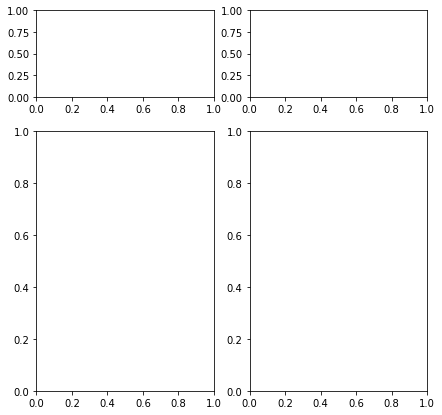

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (7, 7), gridspec_kw={'height_ratios': [1, 3]})
axs

In [ ]:
full_data[full_data['action'] == 6]

,Unnamed: 0,action,frame,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y,ball_carrier,dist_from_basket,closest_def,dist_to_closest_def,shoot_prob,pass
300,300,6,0,46.1990,27.205,43.3060,34.582,19.5680,31.400,46.717,26.340,35.955,26.349,37.3220,17.852,33.2320,18.974,5.8796,1.4771,7.3606,11.047,21.1170,15.700,20.4520,18.401,2,34.742851,2,10.762004,0.442079,0
301,301,6,1,45.0420,27.338,41.2400,35.184,19.1810,31.559,45.750,26.432,36.055,26.494,36.8130,17.675,32.8570,18.887,5.9281,1.4039,7.0964,11.212,20.7690,15.788,20.2770,18.204,2,33.780366,2,9.695198,0.418627,0
302,302,6,2,43.7170,27.112,39.1010,35.764,18.7930,31.733,44.885,26.460,36.110,26.666,36.2520,17.472,32.4130,18.846,5.9670,1.3640,6.9311,11.344,20.2530,15.810,20.0350,18.013,2,32.917394,2,8.777418,0.397193,0
303,303,6,3,42.8790,25.904,37.1260,36.286,18.3850,31.887,44.101,26.384,36.099,26.706,35.6160,17.304,31.5800,18.674,5.9981,1.3527,6.8759,11.441,19.7460,15.780,19.7150,17.854,2,32.130821,2,8.008476,0.378559,0
304,304,6,4,42.6350,25.058,35.1750,36.763,17.9500,31.980,43.380,26.201,36.001,26.545,34.7420,17.112,30.8180,18.588,5.9822,1.3830,6.9354,11.497,19.1710,15.669,19.4100,17.793,2,31.402974,2,7.387014,0.363298,0
305,305,6,5,42.2240,24.658,33.2290,37.085,17.5790,32.076,42.686,26.139,35.846,26.336,33.6500,16.834,30.0240,18.503,5.9305,1.4256,7.0783,11.521,18.9090,15.641,19.0610,17.917,2,30.707131,2,6.842836,0.349919,0
306,306,6,6,41.5920,24.785,31.3980,37.406,17.2060,32.188,42.003,26.211,35.623,26.228,32.3280,16.466,29.1990,18.309,5.8396,1.4677,7.2243,11.580,18.9080,15.697,18.7070,18.144,2,30.027430,2,6.380023,0.338756,0
307,307,6,7,40.8490,25.412,29.5220,37.684,16.8380,32.309,41.337,26.439,35.319,26.317,30.8410,15.995,28.3810,18.122,5.7134,1.5178,7.3406,11.687,19.3340,15.710,18.3210,18.439,2,29.372271,2,6.019236,0.330520,0
308,308,6,8,40.5910,26.918,27.7560,37.941,16.4800,32.463,40.744,26.754,35.020,26.480,29.1430,15.518,27.4210,17.788,5.6005,1.5838,7.3900,11.831,19.7650,15.649,17.9480,18.656,2,28.797466,2,5.730554,0.324224,0
309,309,6,9,40.6330,28.088,26.0920,38.154,16.1090,32.637,40.228,26.924,34.691,26.695,27.3290,14.928,26.4090,17.301,5.5083,1.6548,7.3880,11.983,20.2830,15.529,17.5780,18.714,2,28.293493,2,5.541733,0.320710,0


In [ ]:
# select actions to analyse, 
# for each action, plot on a subplots with number of passes +1, the frames 
# before and after each pass and compare the probabilities with the situation

image = mpimg.imread("drive/MyDrive/DROMB8131 Sports Analytics Project/bball_data_cleaned/data/court.png")

size = np.shape(image)
reshape_size = [size[0]/50, size[1]/100]

def compare_two_frames(pass_frame, fig_save = False):

  fig, ((ax1pre, ax1post), (ax2pre, ax2post)) = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10), gridspec_kw={'height_ratios': [1, 3]})

  for pre_post_frame in range(2):

    if pre_post_frame == 0:
      ax1 = ax1pre
      ax2 = ax2pre
      frame_index = pass_frame - 5
    else:
      ax1 = ax1post
      ax2 = ax2post
      frame_index = pass_frame + 2

    #pre-pass frame
    action_number = full_data['action'].iloc[frame_index]
    frame_number = full_data['frame'].iloc[frame_index]
    #plt.title(f'play number {action_number}', y = 1.8)

    ball = full_data[['ball_x', 'ball_y']].iloc[frame_index]
    home_players_columns = [f'player_h{i}x' for i in range(1, 6)] + [f'player_h{i}y' for i in range(1, 6)]
    home_players = full_data[home_players_columns].iloc[frame_index]
    away_players_columns = [f'player_a{i}x' for i in range(1, 6)] + [f'player_a{i}y' for i in range(1, 6)]
    away_players = full_data[away_players_columns].iloc[frame_index]

    closest_def = full_data['closest_def'].iloc[frame_index]
    closest_def_position = full_data[[f'player_a{closest_def}x'] + [f'player_a{closest_def}y']].iloc[frame_index]

    ball_carrier = full_data['ball_carrier'].iloc[frame_index]
    ball_carrier_position = full_data[[f'player_h{ball_carrier}x'] + [f'player_h{ball_carrier}y']].iloc[frame_index]

    # plots definition
    s = 30
    c = ['r']*5 + ['blue']*5
    scat0 = ax2.scatter([], [] , s = 30, c = 'orange')
    scat1 = ax2.scatter([0]*10, [0]*10, s, c, marker = 'x')
    scat2 = ax2.scatter([], [], s = 50, facecolors='none', edgecolors='blue', marker = 's', label = 'closest defender')
    scat3 = ax2.scatter([], [], s = 50, facecolors='none', edgecolors='r', marker = 's', label = 'ball carrier')
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.legend()
    ax2.set_ylim(0, size[0])
    ax2.set_xlim(0, size[1])

    proba_line, = ax1.plot(np.arange(0, 0+1, 1), [full_data['shoot_prob'].iloc[0]])

    pass_times = []
    proba_at_pass_times = []
    pass_label, = ax1.plot(pass_times, proba_at_pass_times, '^', label = 'pass marker', color='green', markerfacecolor='none')

    ax1.set_xlim(0, 50)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('time in the play')
    ax1.set_ylabel('shoot sucess probability')
    ax1.set_xticklabels([str(0.16*l) + 's' for l in range(0, 50, 10)], minor = False)
    ax1.set_xticks(np.arange(0, 50, 10))
    ax1.legend()

    ball_position = [ball[0]*reshape_size[1], ball[1]*reshape_size[0]]
    home_team_positions = [home_players[:5]*reshape_size[1], home_players[5:]*reshape_size[0]]
    away_team_positions = [away_players[:5]*reshape_size[1], away_players[5:]*reshape_size[0]]

    x = list(home_team_positions[0]) + list(away_team_positions[0])
    y = list(home_team_positions[1]) + list(away_team_positions[1])

    scat0.set_offsets([ball_position[0], ball_position[1]])
    scat1.set_offsets([[x[k], y[k]] for k in range(10)])
    scat2.set_offsets([closest_def_position[0]*reshape_size[1], closest_def_position[1]*reshape_size[0]]) #closest def
    scat3.set_offsets([ball_carrier_position[0]*reshape_size[1], ball_carrier_position[1]*reshape_size[0]]) #ball_carrier

    proba_line.set_data(np.arange(0, frame_number+1, 1), [full_data['shoot_prob'].iloc[l] for l in range(action_number*50, action_number*50+frame_number+1)])

    pass_times = [l - action_number*50 for l in range(action_number*50, action_number*50+frame_number+1) if full_data['pass'].iloc[l] == 1]
    proba_at_pass_times = [full_data['shoot_prob'].iloc[l] for l in pass_times]
    pass_label.set_data(pass_times, proba_at_pass_times)

    ax2.imshow(image)
  plt.show()
  
  if fig_save:
    fig.savefig(f'pass_value_action_{action_number}_frame_{pass_frame}')

In [ ]:
actions_to_analyse = [6, 10, 11, 12]
print('Frames to analyse are the following')
print(list(full_data[full_data['action'].isin(actions_to_analyse)][full_data['pass'] == 1].index))

Frames to analyse are the following
[333, 339, 502, 527, 565, 593, 603, 630, 643]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


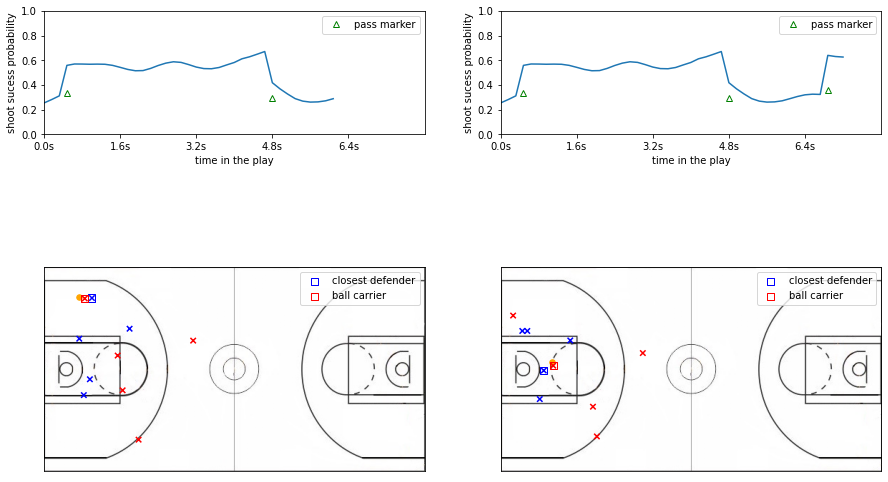

In [ ]:
compare_two_frames(643, fig_save = False)

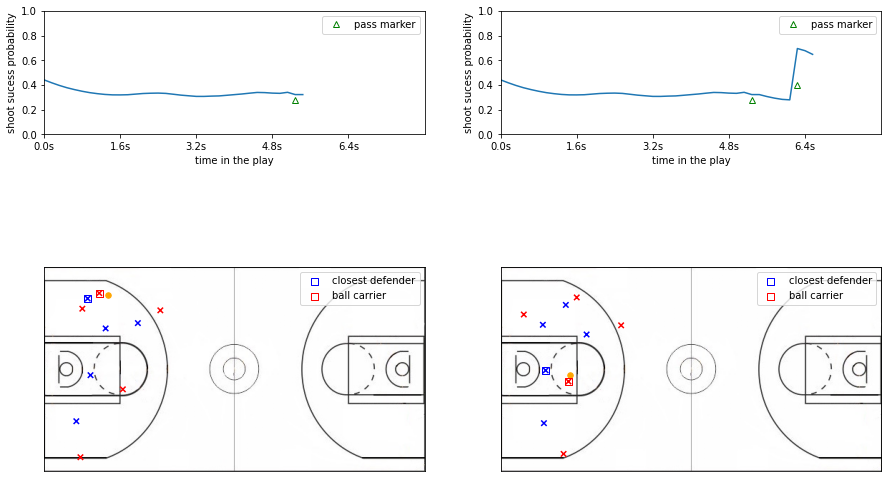

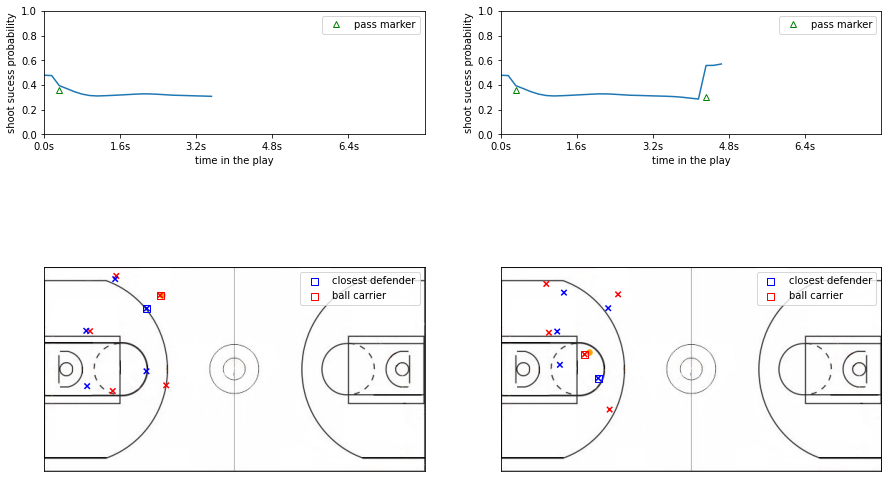

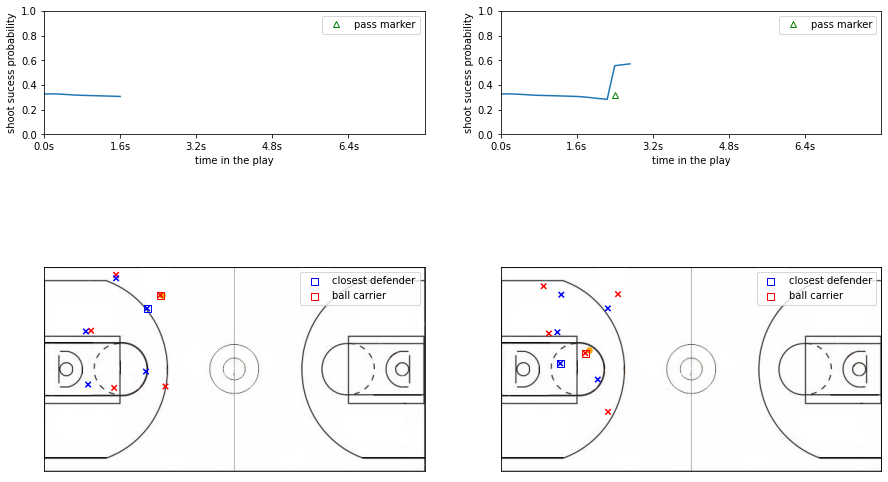

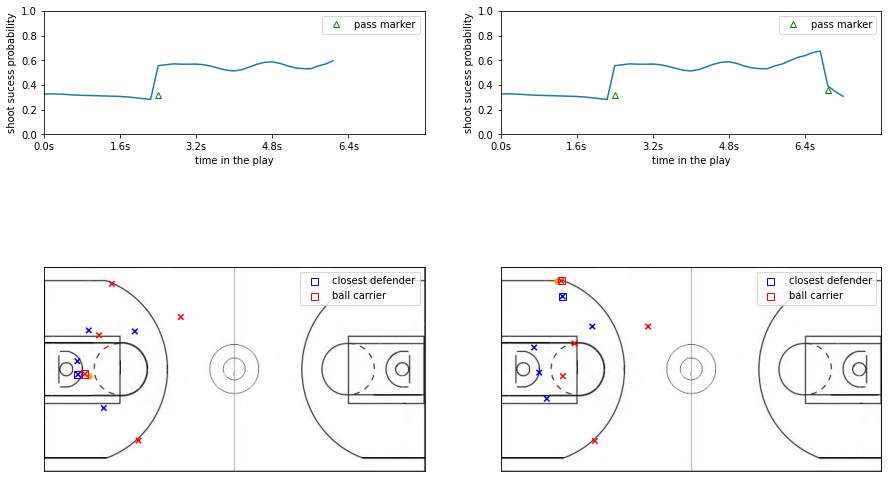

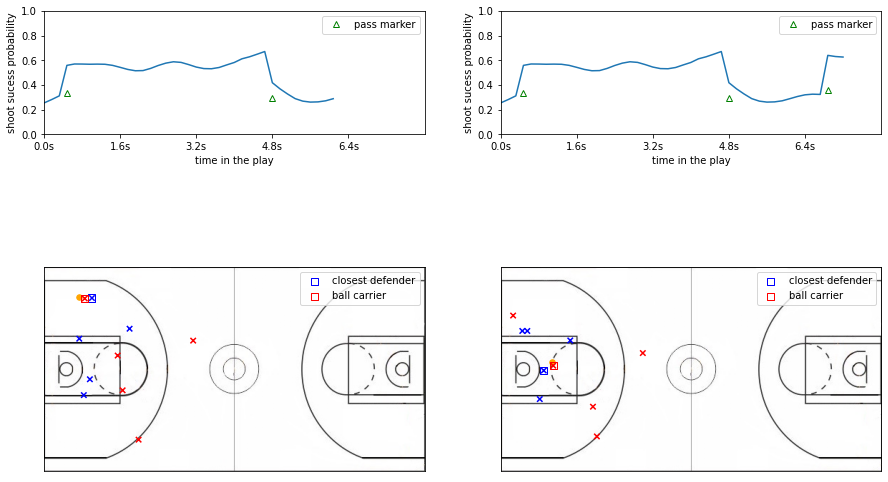

In [ ]:
compare_two_frames(339, fig_save = True)
compare_two_frames(527, fig_save = True)
compare_two_frames(565, fig_save = True)
compare_two_frames(593, fig_save = True)
compare_two_frames(643, fig_save = True)

In [ ]:
shoot_prob = pd.read_csv('drive/MyDrive/DROMB8131 Sports Analytics Project/score_proba_all_players/shoot_proba.csv')

In [ ]:
shoot_prob

,Unnamed: 0,action,frame,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y,p1_dist_from_basket,p2_dist_from_basket,p3_dist_from_basket,p4_dist_from_basket,p5_dist_from_basket,p1_dist_closest_def,p2_dist_closest_def,p3_dist_closest_def,p4_dist_closest_def,p5_dist_closest_def,p1_shoot_prob,p2_shoot_prob,p3_shoot_prob,p4_shoot_prob,p5_shoot_prob
0,0,0,0,36.507,39.350,18.6900,47.883,20.585,42.337,65.627,37.171,28.732,35.769,44.717,19.284,46.886,39.394,43.345,10.0840,25.343,16.602,36.6770,40.4970,21.3370,23.843,23.840885,54.990803,33.212569,34.713053,29.139515,23.840885,54.990803,33.212569,34.713053,29.139515,0.544894,0.003856,0.294387,0.250378,0.414587
1,1,0,1,34.941,38.831,16.7450,47.850,18.758,42.402,63.680,36.548,27.837,35.821,42.882,19.133,44.534,38.184,41.579,9.7938,24.777,16.601,34.3950,39.8780,20.0700,24.229,23.337470,52.954497,31.434370,33.258770,26.886631,23.337470,52.954497,31.434370,33.258770,26.886631,0.554865,0.006796,0.347568,0.293012,0.475217
2,2,0,2,33.812,38.373,15.0330,47.683,17.122,42.501,61.744,35.971,26.989,35.694,41.221,18.919,42.202,36.927,39.934,9.5226,24.224,16.470,32.3290,38.9650,19.0970,24.510,22.884877,50.939458,29.847033,31.935220,24.663525,22.884877,50.939458,29.847033,31.935220,24.663525,0.563442,0.011571,0.394336,0.332591,0.527633
3,3,0,3,31.883,36.740,13.5320,47.422,15.612,42.571,59.841,35.361,26.141,35.427,39.646,18.616,39.918,35.669,38.374,9.3071,23.678,16.247,30.1210,37.9920,18.3750,24.726,22.474277,48.950093,28.373522,30.689656,22.297146,22.474277,48.950093,28.373522,30.689656,22.297146,0.570906,0.019009,0.435927,0.369687,0.574032
4,4,0,4,27.635,35.908,12.2350,47.096,14.187,42.597,57.936,34.731,25.159,35.181,38.121,18.304,37.699,34.510,36.969,9.1729,23.097,16.026,27.8780,37.2810,17.7550,24.814,22.097250,46.955388,26.965590,29.562612,20.073212,22.097250,46.955388,26.965590,29.562612,20.073212,0.577492,0.030340,0.473210,0.402533,0.608530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,199,45,24.898,43.811,10.3290,47.740,11.560,39.080,18.217,32.518,14.841,33.678,26.447,42.977,25.011,39.308,26.674,12.1280,17.052,32.223,7.2961,10.4680,6.2273,17.405,22.801312,9.755584,23.062704,19.519597,15.274348,22.801312,9.755584,23.062704,19.519597,15.274348,0.564986,0.663357,0.560116,0.615770,0.654417
9996,9996,199,46,25.610,44.174,9.5075,47.731,11.283,39.214,17.259,31.884,14.784,33.723,26.968,43.138,25.554,39.795,26.306,12.0670,17.867,30.589,7.2867,10.1920,6.1847,17.218,22.867246,8.662940,23.516549,19.285334,15.540015,22.867246,8.662940,23.516549,19.285334,15.540015,0.563769,0.659802,0.551370,0.618676,0.652839
9997,9997,199,47,26.133,45.399,8.6860,47.774,10.974,39.446,16.222,31.331,14.552,33.545,27.202,43.315,26.035,40.130,25.996,12.0540,18.696,28.691,7.1920,9.9881,6.1676,17.193,23.013858,7.609655,23.802101,19.065333,15.763058,23.013858,7.609655,23.802101,19.065333,15.763058,0.561036,0.654681,0.545679,0.621319,0.651431
9998,9998,199,48,26.504,45.829,7.9325,47.944,10.686,39.684,15.313,30.536,14.138,33.264,27.272,43.366,26.364,40.366,25.788,12.1000,18.960,27.229,7.0201,9.8184,6.1705,17.345,23.301753,6.451609,23.886062,18.881709,15.977496,23.301753,6.451609,23.886062,18.881709,15.977496,0.555556,0.647089,0.543978,0.623463,0.650004


In [ ]:
def distance(x1, y1, x2, y2):
  x = x1 - x2
  y = y1 - y2
  return np.sqrt(x**2 + y**2)

def dist_to_closest_def(x, y, X_away, Y_away):
  dist_list = [distance(x, y, X_away[i], Y_away[i]) for i in range(5)]
  return min(dist_list)

j=1
print(dist_to_closest_def(shoot_prob[f'player_h{j}x'].iloc[0], shoot_prob[f'player_h{j}y'].iloc[0], [shoot_prob[f'player_a{i}x'].iloc[0] for i in range (1, 6)], [shoot_prob[f'player_a{i}y'].iloc[0] for i in range (1, 6)]))


for j in range(1, 6):
  shoot_prob[f'p{j}_dist_closest_def'] = shoot_prob.apply(lambda x: dist_to_closest_def(x[f'player_h{j}x'], x[f'player_h{j}y'], [x[f'player_a{i}x'] for i in range (1, 6)], [x[f'player_a{i}y'] for i in range (1, 6)]), axis = 1)

#shoot_prob[f'p{1}_dist_closest_def'] = shoot_prob.apply(lambda x: np.average([x[f'player_a{i}x'] for i in range (1, 6)]), axis = 1)

5.860814021959754


In [ ]:
shoot_prob.describe()

,Unnamed: 0,action,frame,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y,p1_dist_from_basket,p2_dist_from_basket,p3_dist_from_basket,p4_dist_from_basket,p5_dist_from_basket,p1_dist_closest_def,p2_dist_closest_def,p3_dist_closest_def,p4_dist_closest_def,p5_dist_closest_def,p1_shoot_prob,p2_shoot_prob,p3_shoot_prob,p4_shoot_prob,p5_shoot_prob
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,99.500000,24.500000,26.468514,26.344178,15.347678,37.398513,13.81669,32.342889,25.880983,31.040321,21.285220,28.680672,23.274475,20.095102,18.754118,22.018876,15.287836,13.306005,13.511162,18.045286,16.538889,24.722944,13.672266,25.441302,18.668688,19.985288,18.164518,17.440716,13.149203,6.969801,7.261188,6.956310,6.540464,4.998104,0.592476,0.570894,0.589054,0.610458,0.642558
std,2886.89568,57.737192,14.431591,10.758096,12.518658,9.788944,11.406657,6.59795,7.953936,10.623670,10.537738,8.483473,7.598224,11.031577,10.648229,8.233817,7.983719,8.664540,10.787525,6.433774,7.754204,8.205805,10.572314,5.459894,6.957431,6.505922,7.324253,7.502313,5.900009,5.183685,3.926609,4.381885,4.536838,3.873317,3.179568,0.072225,0.107196,0.101211,0.057491,0.041855
min,0.00000,0.000000,0.000000,-2.761000,0.213700,0.120870,0.131760,-1.69720,5.202400,1.850200,1.141500,3.619400,4.717200,-2.780700,0.454090,2.095100,5.981200,-2.203400,-0.014500,1.020900,1.063600,-0.818100,-2.149500,1.749600,6.824700,0.724162,0.773217,0.442159,0.358615,0.170660,0.178045,0.045000,0.052154,0.123556,0.131000,0.006435,0.000113,0.000587,0.103947,0.154578
25%,2499.75000,49.750000,12.000000,18.425750,15.947750,7.198250,32.557500,8.60490,28.552000,18.349000,25.268500,15.482000,24.142000,14.381000,12.532500,12.000750,16.198750,7.933550,4.251375,8.628100,12.449000,10.144500,15.848000,9.274150,19.250500,12.874992,14.481582,12.365233,12.566366,9.707478,3.683009,4.103609,3.490528,3.317905,2.599338,0.555518,0.538372,0.563449,0.568632,0.642453
50%,4999.50000,99.500000,24.500000,26.832000,27.062000,12.819000,40.460500,12.75950,33.940500,26.908500,32.418000,20.505000,29.414500,23.846500,17.814500,18.396000,20.858000,13.572500,12.015000,12.108000,16.517500,16.182500,23.819000,13.111500,25.020500,21.070346,20.875961,18.293527,18.011292,12.614507,6.528384,6.327557,5.962840,5.888102,4.187826,0.593724,0.596951,0.623828,0.628714,0.658832
75%,7499.25000,149.250000,37.000000,34.439000,36.590750,22.912500,46.967000,18.15350,38.209000,32.674000,38.613250,26.979750,34.148500,30.732000,26.681000,24.121250,27.218250,21.985500,17.153000,17.876000,21.348750,22.804500,33.506000,17.639000,31.008000,23.303693,24.158484,22.884537,22.601133,15.767010,9.738743,9.700496,9.416431,9.227289,6.637584,0.658215,0.653357,0.659566,0.660805,0.663810
max,9999.00000,199.000000,49.000000,93.996000,50.000000,63.235000,50.940000,43.57900,48.240000,77.816000,49.715000,76.199000,44.803000,72.625000,48.287000,68.730000,44.058000,51.989000,48.812000,42.055000,47.325000,48.191000,48.725000,39.597000,47.296000,53.154923,65.937378,61.138848,40.817463,38.361189,22.395091,42.380483,41.028293,22.755488,29.553618,0.665385,0.665385,0.665385,0.665385,0.665385


In [ ]:
shoot_prob[f"p{j}_dist_from_basket"] = shoot_prob.apply(lambda x: distance(x[f'player_h{j}x'], x[f'player_h{j}y'], 12, 25), axis=1)

In [ ]:
shoot_prob.to_csv('shoot_proba_corrected.csv')

In [ ]:
shoot_prob.describe()

,Unnamed: 0,action,frame,ball_x,ball_y,player_h1x,player_h1y,player_a1x,player_a1y,player_h2x,player_h2y,player_a2x,player_a2y,player_h3x,player_h3y,player_a3x,player_a3y,player_h4x,player_h4y,player_a4x,player_a4y,player_h5x,player_h5y,player_a5x,player_a5y,p1_dist_from_basket,p2_dist_from_basket,p3_dist_from_basket,p4_dist_from_basket,p5_dist_from_basket,p1_dist_closest_def,p2_dist_closest_def,p3_dist_closest_def,p4_dist_closest_def,p5_dist_closest_def,p1_shoot_prob,p2_shoot_prob,p3_shoot_prob,p4_shoot_prob,p5_shoot_prob
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,99.500000,24.500000,26.468514,26.344178,15.347678,37.398513,13.81669,32.342889,25.880983,31.040321,21.285220,28.680672,23.274475,20.095102,18.754118,22.018876,15.287836,13.306005,13.511162,18.045286,16.538889,24.722944,13.672266,25.441302,18.668688,19.985288,18.164518,17.440716,13.149203,6.969801,7.261188,6.956310,6.540464,4.998104,0.592476,0.570894,0.589054,0.610458,0.642558
std,2886.89568,57.737192,14.431591,10.758096,12.518658,9.788944,11.406657,6.59795,7.953936,10.623670,10.537738,8.483473,7.598224,11.031577,10.648229,8.233817,7.983719,8.664540,10.787525,6.433774,7.754204,8.205805,10.572314,5.459894,6.957431,6.505922,7.324253,7.502313,5.900009,5.183685,3.926609,4.381885,4.536838,3.873317,3.179568,0.072225,0.107196,0.101211,0.057491,0.041855
min,0.00000,0.000000,0.000000,-2.761000,0.213700,0.120870,0.131760,-1.69720,5.202400,1.850200,1.141500,3.619400,4.717200,-2.780700,0.454090,2.095100,5.981200,-2.203400,-0.014500,1.020900,1.063600,-0.818100,-2.149500,1.749600,6.824700,0.724162,0.773217,0.442159,0.358615,0.170660,0.178045,0.045000,0.052154,0.123556,0.131000,0.006435,0.000113,0.000587,0.103947,0.154578
25%,2499.75000,49.750000,12.000000,18.425750,15.947750,7.198250,32.557500,8.60490,28.552000,18.349000,25.268500,15.482000,24.142000,14.381000,12.532500,12.000750,16.198750,7.933550,4.251375,8.628100,12.449000,10.144500,15.848000,9.274150,19.250500,12.874992,14.481582,12.365233,12.566366,9.707478,3.683009,4.103609,3.490528,3.317905,2.599338,0.555518,0.538372,0.563449,0.568632,0.642453
50%,4999.50000,99.500000,24.500000,26.832000,27.062000,12.819000,40.460500,12.75950,33.940500,26.908500,32.418000,20.505000,29.414500,23.846500,17.814500,18.396000,20.858000,13.572500,12.015000,12.108000,16.517500,16.182500,23.819000,13.111500,25.020500,21.070346,20.875961,18.293527,18.011292,12.614507,6.528384,6.327557,5.962840,5.888102,4.187826,0.593724,0.596951,0.623828,0.628714,0.658832
75%,7499.25000,149.250000,37.000000,34.439000,36.590750,22.912500,46.967000,18.15350,38.209000,32.674000,38.613250,26.979750,34.148500,30.732000,26.681000,24.121250,27.218250,21.985500,17.153000,17.876000,21.348750,22.804500,33.506000,17.639000,31.008000,23.303693,24.158484,22.884537,22.601133,15.767010,9.738743,9.700496,9.416431,9.227289,6.637584,0.658215,0.653357,0.659566,0.660805,0.663810
max,9999.00000,199.000000,49.000000,93.996000,50.000000,63.235000,50.940000,43.57900,48.240000,77.816000,49.715000,76.199000,44.803000,72.625000,48.287000,68.730000,44.058000,51.989000,48.812000,42.055000,47.325000,48.191000,48.725000,39.597000,47.296000,53.154923,65.937378,61.138848,40.817463,38.361189,22.395091,42.380483,41.028293,22.755488,29.553618,0.665385,0.665385,0.665385,0.665385,0.665385
